# Generalized MLM distribution simulation

In [1]:
library(evd)
library(maxstablePCA)
library(ggplot2)
library(dplyr)
library(GGally)
library(graphicalExtremes)
library(Matrix)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2



### setup parameters and simulate data

In [2]:
set.seed(86420)
s <- 100

In [3]:
Z <- rmvevd(10000, dep = .5, model = "log", d = 2, mar = c(1,1,1))

In [4]:
Z2 <- rmstable(10000, d = 2, par = matrix(c(0, .6, .6, 0), 2, 2))

In [5]:
A <- matrix(c(0.8, 0.05, 0.6, 0.45, 0.2, 0.95, 0.4, 0.55), 4, 2)
X <- t(maxmatmul(A, t(Z)))
X2 <- t(maxmatmul(A, t(Z2)))

In [6]:
A

0.80,0.20
0.05,0.95
0.60,0.40
0.45,0.55


In [7]:
Xtrafo <- transform_unitpareto(X)

# max-stable PCA for X

In [8]:
summary(apply(Xtrafo, 1, max))

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
    1.000     1.580     2.562    13.786     5.308 10000.000 

In [9]:
length(which(apply(Xtrafo, 1, max) > s))

[1] 141

In [10]:
maxPCA1 <- max_stable_prcomp(Xtrafo, p = 1, s = s, n_initial_guesses = 15000, norm = "linfty")
maxPCA2 <- max_stable_prcomp(Xtrafo, p = 2, s = s, n_initial_guesses = 15000, norm = "linfty")
maxPCA3 <- max_stable_prcomp(Xtrafo, p = 3, s = s, n_initial_guesses = 15000, norm = "linfty")
maxPCA4 <- max_stable_prcomp(Xtrafo, p = 4, s = s, n_initial_guesses = 15000, norm = "linfty")

### inspect relevant output 

In [11]:
maxPCA2

$p
[1] 2

$d
[1] 4

$decoder_matrix
            [,1]      [,2]
[1,] 1.113205334 0.1178866
[2,] 0.004055144 1.0324646
[3,] 0.943135665 0.5481915
[4,] 0.726003414 0.7855713

$encoder_matrix
           [,1]      [,2]      [,3]       [,4]
[1,] 0.89830691 0.1493983 0.1277844 0.10263591
[2,] 0.02084733 0.9685562 0.0318197 0.07499711

$reconstr_matrix
           [,1]      [,2]       [,3]       [,4]
[1,] 1.00000005 0.1663109 0.14225032 0.11425484
[2,] 0.02152413 1.0000000 0.03285272 0.07743186
[3,] 0.84722529 0.5309542 0.12051806 0.09679959
[4,] 0.65217389 0.7608700 0.09277194 0.07451402

$loss_fctn_value
[1] 0.09400289

$optim_conv_status
[1] 4

$s
[1] 100

$starting_vals
$starting_vals$decoder_matrix_x0
          [,1]      [,2]
[1,] 1.0000000 0.3224842
[2,] 0.9329724 1.0000000
[3,] 0.8991738 0.4720304
[4,] 0.4290549 0.8517225

$starting_vals$encoder_matrix_x0
          [,1]      [,2]      [,3]      [,4]
[1,] 0.9176525 0.1697999 0.5183002 0.1026359
[2,] 0.7946069 0.9461765 0.2165304 0.9791701

In [12]:
maxPCA3$optim_conv_status

[1] 4

### report rounded estimated matrices

In [13]:
round(maxPCA2$decoder_matrix, 2)

1.11,0.12
0.00,1.03
0.94,0.55
0.73,0.79


In [14]:
round(maxPCA2$encoder_matrix, 2)

0.90,0.15,0.13,0.10
0.02,0.97,0.03,0.07


In [15]:
round(maxPCA2$reconstr_matrix, 2)

1.00,0.17,0.14,0.11
0.02,1.00,0.03,0.08
0.85,0.53,0.12,0.10
0.65,0.76,0.09,0.07


#### rescale the matrices such that the largest rowwise entries of $\hat W$ are equal to one

In [16]:
round(maxmatmul(maxPCA2$decoder_matrix, diag(apply(maxPCA2$encoder_matrix, 1, max))), 2)

1.00,0.11
0.00,1.00
0.85,0.53
0.65,0.76


In [17]:
round(t(apply(maxPCA2$encoder_matrix, 1, function(z) z / max(z))), 2)

1.00,0.17,0.14,0.11
0.02,1.00,0.03,0.08


# Elbow plot for reconstruction error 

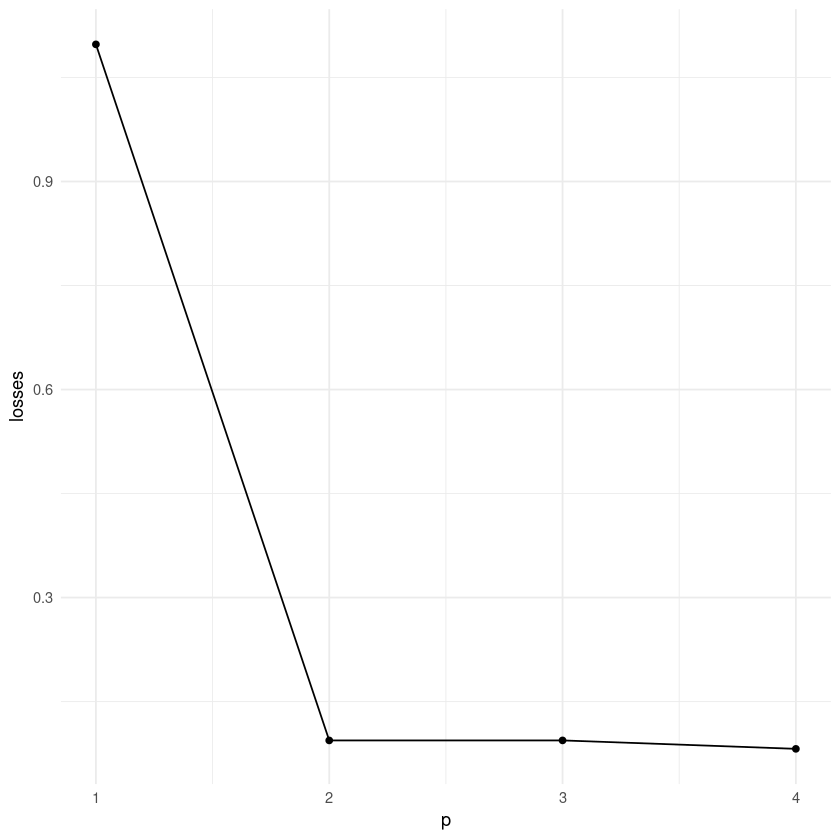

In [18]:
plotdat <- data.frame(p = 1:4, losses = c(
    maxPCA1$loss_fctn_value,
    maxPCA2$loss_fctn_value,
    maxPCA3$loss_fctn_value,
    maxPCA4$loss_fctn_value   
))

pe <- ggplot(aes(x = p, y = losses), data = plotdat) + geom_line() + geom_point() + theme_minimal()
pe

In [19]:
ggsave("genmlm_elbow.pdf", pe)

Saving 6.67 x 6.67 in image


# pairplot to visually inspect reconstruction

In [20]:
datX <- data.frame(X)
rec <- t(maxmatmul(maxPCA2$reconstr_matrix, t(as.matrix(datX))))
datX$is_rec = "original"
datrec <- data.frame(rec)
datrec$is_rec = "reconstruction"
names(datrec) <- names(datX)
plot_datX <- full_join(datX, datrec)

Joining with `by = join_by(X1, X2, X3, X4, is_rec)`


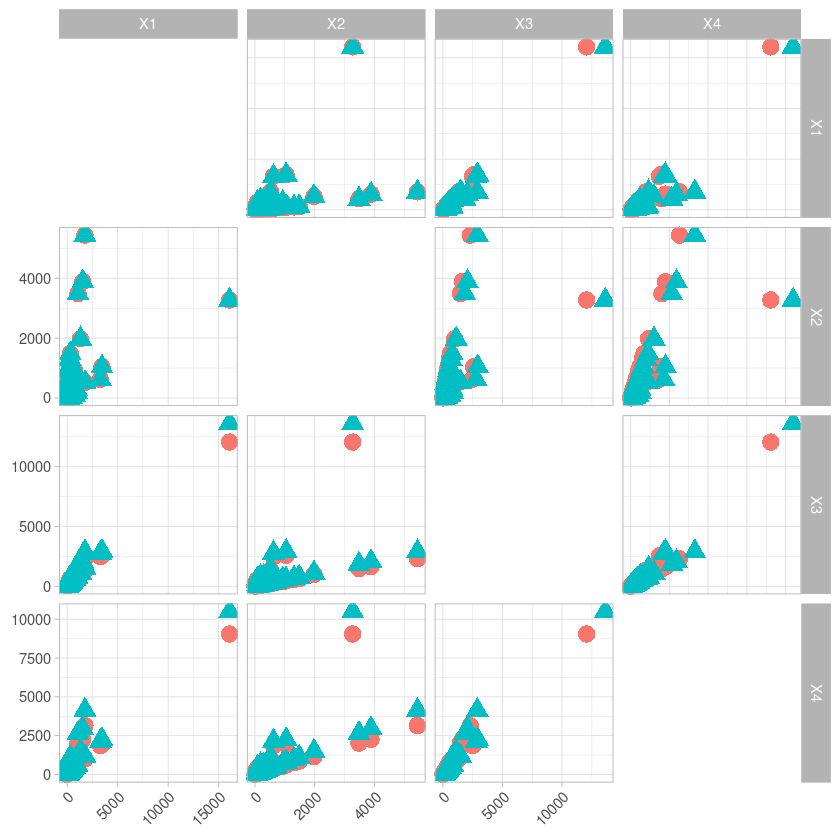

In [21]:
p <- ggpairs(
    plot_datX, 
    aes(color = is_rec, shape = is_rec, size = 2),
    columns = 1:4,
    upper = list(continuous = "points", combo = "dot_no_facet"),
    diag = list(continuous = "blankDiag", discrete = "barDiag", na = "naDiag")
) + 
theme_light() +
theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust=1))

p

In [22]:
plot_datX %>% group_by(is_rec) %>% summarize(max(X1))

is_rec,max(X1)
<chr>,<dbl>
original,16083.69
reconstruction,16083.69


In [23]:
ggsave("genmlm.png", p)

Saving 6.67 x 6.67 in image


# Comparison to other methodologies 

In [24]:
Xsphere1 <- t(apply(Xtrafo, 1, function(z) z / max(z)))
Xsphere1 <- Xsphere1[which(apply(Xtrafo, 1, max) > 100), ]

In [25]:
length(which(apply(Xtrafo, 1, max) > 100))

[1] 141

In [36]:
specdecomp1 <- eigen(t(Xsphere1) %*% Xsphere1 / 100)
specdecomp1

eigen() decomposition
$values
[1] 2.835024402 0.319985000 0.018958945 0.003998635

$vectors
           [,1]       [,2]       [,3]       [,4]
[1,] -0.5067064 -0.6040583  0.5270575  0.3171319
[2,] -0.4965872  0.7368990  0.4416450 -0.1238171
[3,] -0.4986745 -0.2659624 -0.3290380 -0.7565195
[4,] -0.4979694  0.1461420 -0.6472202  0.5583681


In [27]:
rec1 <- X %*% specdecomp1$vectors[1:4, 1:2] %*% t(specdecomp1$vectors[1:4, 1:2])

plotdat_DS1 <- data.frame(X)
tmp <- data.frame(rec1)
plotdat_DS1 <- full_join(plotdat_DS1, tmp)
plotdat_DS1$is_rec <- c(rep(F, 10000), rep(T, 10000))

Joining with `by = join_by(X1, X2, X3, X4)`


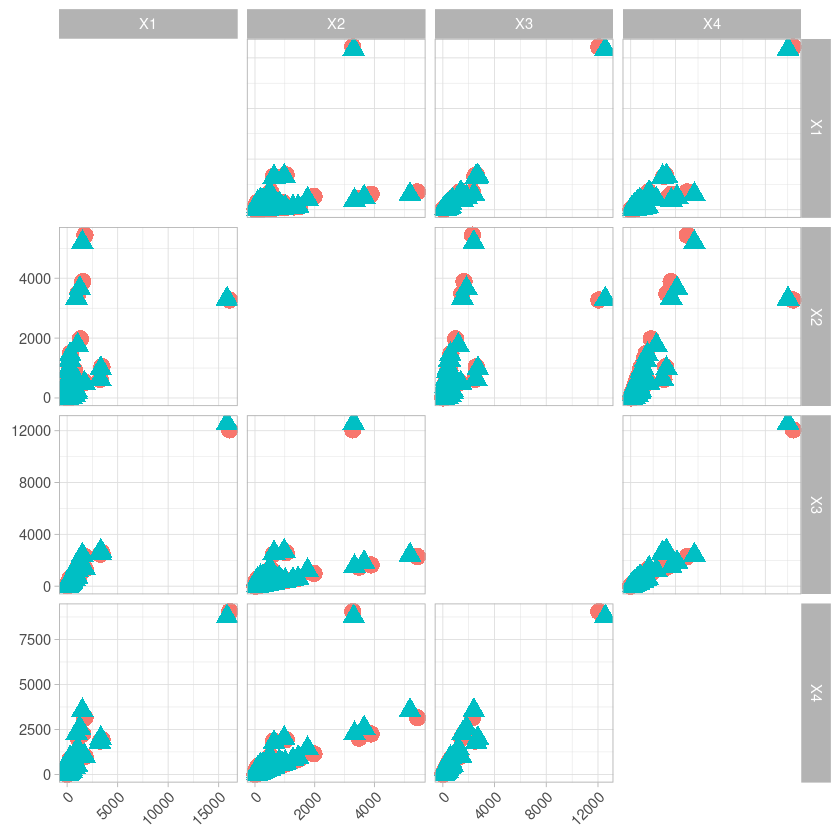

In [28]:
ggpairs(plotdat_DS1,     
        aes(color = is_rec, shape = is_rec, size = 2),
        columns = 1:4,
        upper = list(continuous = "points", combo = "dot_no_facet"),
        diag = list(continuous = "blankDiag", discrete = "barDiag", na = "naDiag")
) + 
theme_light() +
theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust=1))

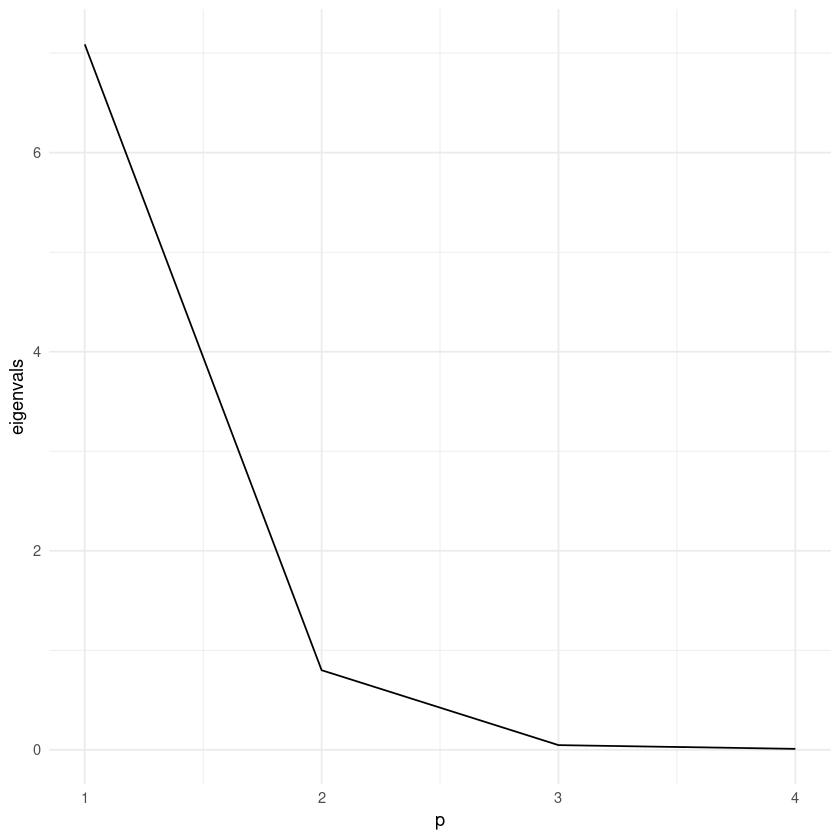

In [29]:
screeplotdat <- data.frame(p = 1:4, eigenvals = specdecomp1$values)

ggplot(aes(x = p, y = eigenvals), data = screeplotdat) + 
geom_line() + 
theme_minimal()

# PCA as by Cooley and Thibaud 

In [30]:
# Tail pairwise dependence matrix code by Yiang 

decls <- function(x, th, k) {
    ## Ordinary decluster.
    id.big <- which(x > th)
    id.dif <- diff(id.big)
    tick <- which(id.dif >= k)
    start <- id.big[c(1, tick + 1)]              # Where a new cluster begins
    end <- c(id.big[tick], last(id.big, 1))
    n <- length(start)
    id.res <- rep(0, n)
    for ( i in 1 : n) {
        temp <- x[start[i] : end[i]]
        id.res[i] <- which(temp == max(temp, na.rm = TRUE))[1] + start[i] - 1
    }
    id.res
}

rw.Sigma <- function(X, u = 0.98, decluster = F) {
    ## Compute TPDM
    P <- ncol(X)                      # Number of stations
    M <- nrow(X)                      # Number of obs
    Sigma <- matrix(0, P, P)
    for ( i in 1 : P) {
        if (i %% 5 == 0) print(i)
        for ( j in 1 : P) {
            r <- sqrt(X[, i] ^ 2 + X[, j] ^ 2)
            w1 <- X[, i] / r
            w2 <- X[, j] / r
            th <- quantile(r, u, na.rm = TRUE)
            if(decluster) {
                id <- decls(r, th, 5)
            } else {
                id <- which(r > th)
            } 
            Sigma[i, j] <- sum(w1[id] * w2[id], na.rm = TRUE) / (length(id)) * 2
        }
    }
    Sigma
}

In [37]:
# use a multiplicatively rescaled estimator to ensure that the ecdf does not take the values 0 and 1.
ecdf_shifted <- function(z) length(z) / (length(z) + 1) * ecdf(z)(z)

In [38]:
# Transform data to approximately 2-Fréchet margins 
Xtrafo_2frech <- apply(Xtrafo, 2, function(z) 1 / sqrt(-log(ecdf_shifted(z))))

In [39]:
X2sphere <- t(apply(Xtrafo_2frech, 1, function(z) z / sqrt(sum(z^2))))
rownorms <- apply(Xtrafo_2frech, 1, function(z) sqrt(sum(z^2)))

# for t = 15 we have the same number of observations exceeding the threshold as for the other procedure
X2sphere_extr <- X2sphere[which(rownorms > 15), ]
tpdm <- t(X2sphere_extr) %*% X2sphere_extr / 117

In [40]:
quantile(rownorms, c(0.5, 0.75, 0.9, 0.95, 0.99))

50%       75%       90%       95%       99% 
 2.458775  3.768344  6.181558  8.833716 19.457524

In [41]:
length(which(rownorms > 15))

[1] 175

In [42]:
specdecomp_cy <- eigen(tpdm)

In [43]:
specdecomp_cy$vectors[,1] <- -specdecomp_cy$vectors[,1]

In [45]:
specdecomp_cy

eigen() decomposition
$values
[1] 1.4365609043 0.0543834992 0.0041232553 0.0006588369

$vectors
          [,1]       [,2]       [,3]        [,4]
[1,] 0.4984021 -0.5884568  0.5584348  0.30571964
[2,] 0.4843410  0.7601128  0.4220674 -0.09747521
[3,] 0.5079594 -0.2541479 -0.3020209 -0.76561703
[4,] 0.5089070  0.1065640 -0.6471423  0.55755238


Saving 6.67 x 6.67 in image


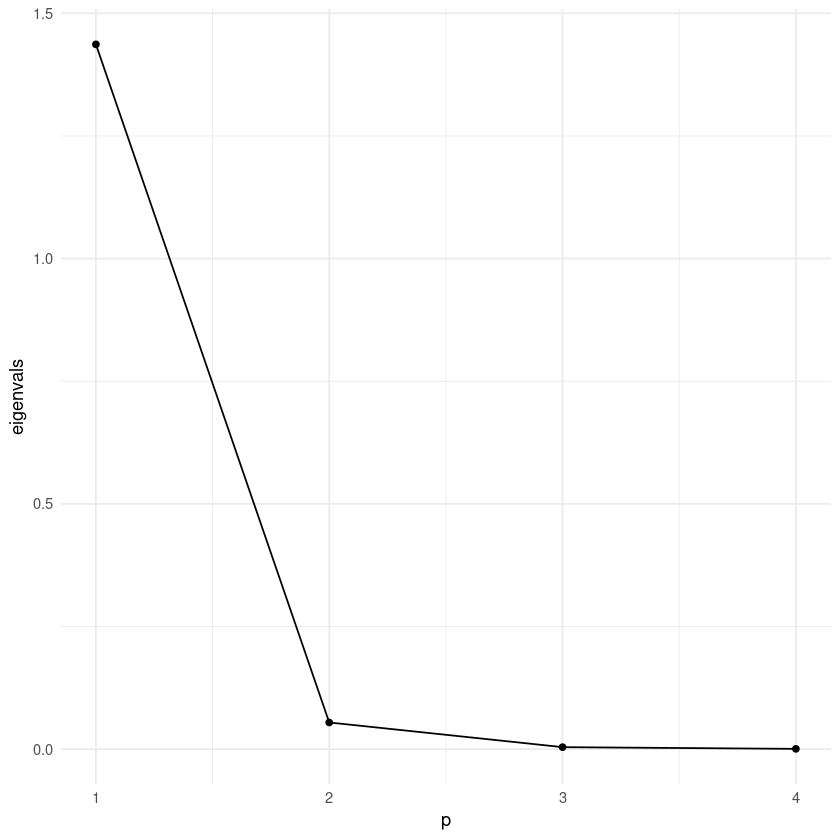

In [46]:
elbow_dat_cy <- data.frame(p = 1:4, eigenvals = specdecomp_cy$values)
elbow_cy <- ggplot(aes(x = p, y = eigenvals), data = elbow_dat_cy) +
geom_line() + 
geom_point () + 
theme_minimal()

ggsave("elbow_epca_cy_genmlm.pdf", elbow_cy)
elbow_cy

In [47]:
##applies the transformation t
trans <- function(x)
{
    ##because it takes an exponential, this function flakes out if x is too big
    ##hence for big values of x, we return x
    v <- log(1 + exp(x))
    id <- which(x < -20)
    v[!is.finite(v)] <- x[!is.finite(v)]
    v[id] <- exp(x[id])
    return(v)
}

##applies the inverse transformation t^{-1}
invTrans <- function(v)
{
    ##same trickeration for big values of v
    ##still returns -Inf if v is machine zero
    x <- log(exp(v) - 1)
    x[!is.finite(x) & v > 1 & !is.na(x)] <- v[!is.finite(x) & v > 1 &
                                                  !is.na(x)]

    return(x)
}

In [48]:
enc_cy <- t(specdecomp_cy$vectors[, 1:2]) %*% t(invTrans(Xtrafo_2frech))
rec_cy <- t(specdecomp_cy$vectors[, 1:2] %*% trans(enc_cy))

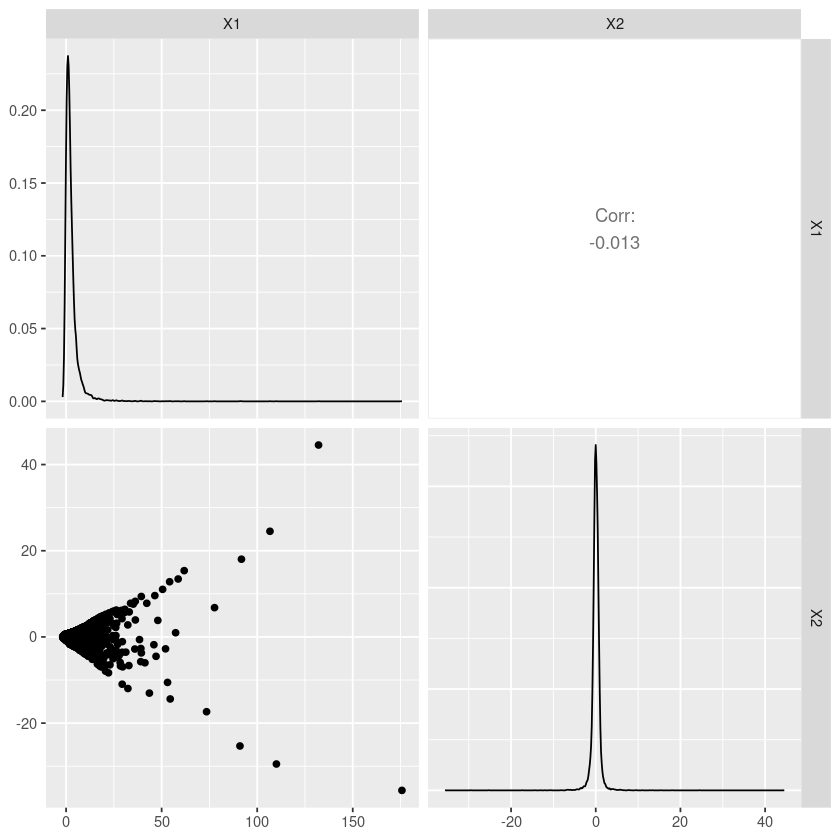

In [49]:
ggpairs(data.frame(t(enc_cy)))

In [50]:
dim(rec_cy)

[1] 10000     4

Joining with `by = join_by(X1, X2, X3, X4)`


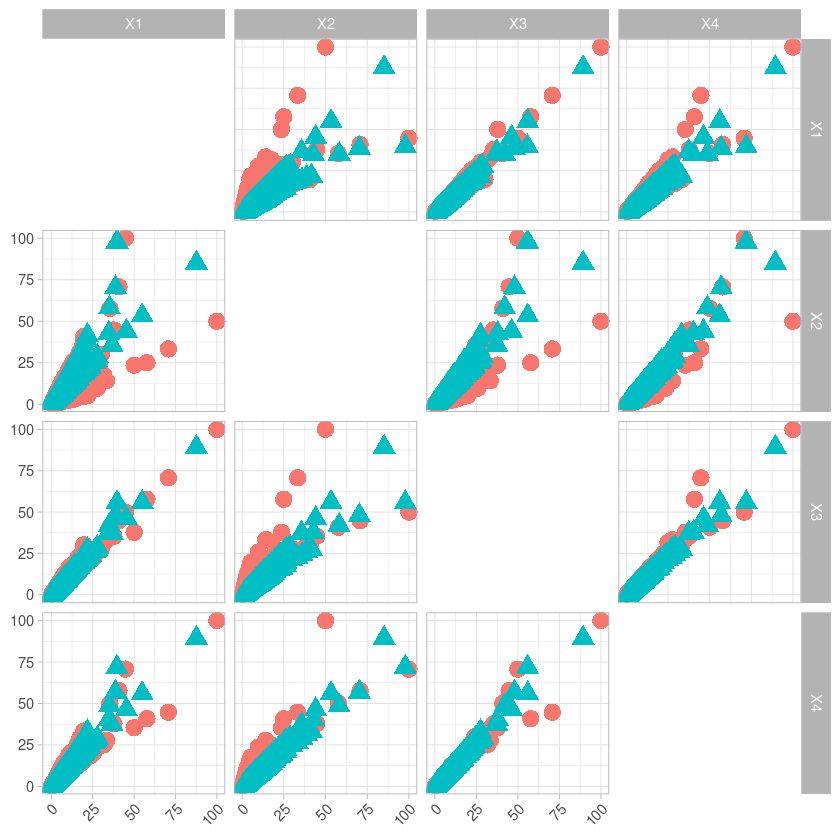

In [51]:
plot_dat <- data.frame(Xtrafo_2frech)
tmp <- data.frame(rec_cy)
plot_dat <- full_join(plot_dat, tmp)
plot_dat$is_rec <- c(rep("False", 10000), rep("True", 10000))


ggpairs(plot_dat,     
        aes(color = is_rec, shape = is_rec, size = 2),
        columns = 1:4,
        upper = list(continuous = "points", combo = "dot_no_facet"),
        diag = list(continuous = "blankDiag", discrete = "barDiag", na = "naDiag")
) + 
theme_light() +
theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust=1))

# Spherical K-means

In [52]:
library(skmeans)

In [53]:
kmeanserrs = data.frame(k = 1:4, errs = NA)
kmeansclusterings = list()
for(k in 2:4) {
    tmp <- skmeans::skmeans(X[which(rowSums(X) > 250), ], k = k)
    kmeansclusterings[[k]] <- tmp
    kmeanserrs[k,2] <- tmp$value
}

Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_line()`).”


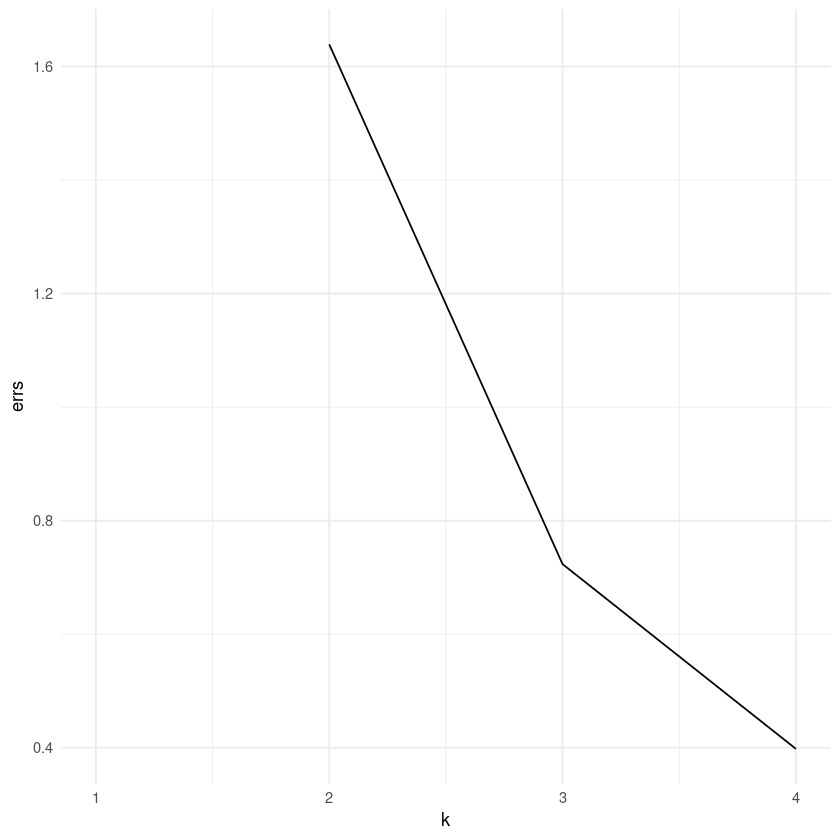

In [54]:
ggplot(aes(x = k, y = errs), data = kmeanserrs) + 
geom_line() +
theme_minimal()